<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-255-Data_Mining/blob/main/Assignment_9/e)_Anomaly_Detection_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pyod pandas matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=ade2511c9574bc10c8b900305a42af79a73721ffe7d5e0eb31b2603bb0e00a17
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [10]:
# Load the dataset
file_path = '/content/amazon_trends.csv'
data = pd.read_csv(file_path)

In [11]:
# Convert 'Date' to datetime format and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

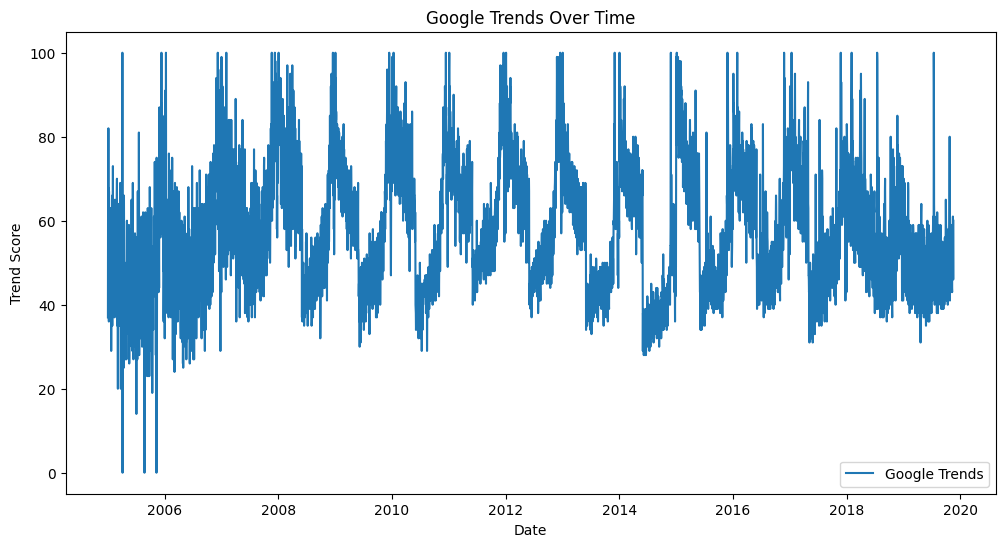

In [12]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Google_Trends'], label='Google Trends')
plt.title('Google Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Trend Score')
plt.legend()
plt.show()

In [13]:
# Calculate Z-Scores
data['Z_Score'] = (data['Google_Trends'] - data['Google_Trends'].mean()) / data['Google_Trends'].std()

# Define a threshold for anomalies
threshold = 3
data['Anomaly_Point'] = np.abs(data['Z_Score']) > threshold

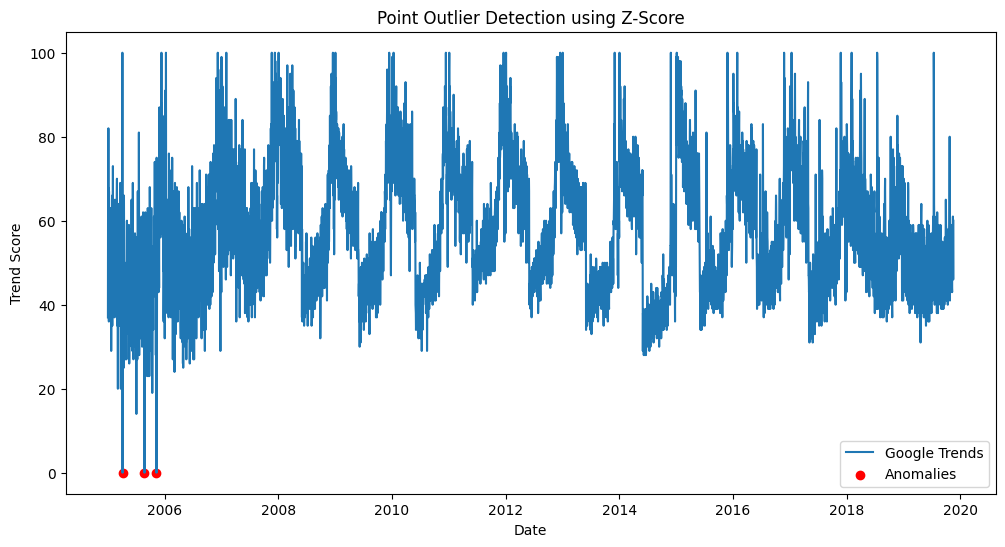

In [14]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Google_Trends'], label='Google Trends')
plt.scatter(data.index[data['Anomaly_Point']], data['Google_Trends'][data['Anomaly_Point']], color='red', label='Anomalies')
plt.title('Point Outlier Detection using Z-Score')
plt.xlabel('Date')
plt.ylabel('Trend Score')
plt.legend()
plt.show()

In [15]:
# Define window size
window_size = 30

# Calculate rolling mean and std
data['Rolling_Mean'] = data['Google_Trends'].rolling(window=window_size).mean()
data['Rolling_Std'] = data['Google_Trends'].rolling(window=window_size).std()

# Detect anomalies
data['Anomaly_Subsequence'] = np.abs(data['Google_Trends'] - data['Rolling_Mean']) > (2 * data['Rolling_Std'])


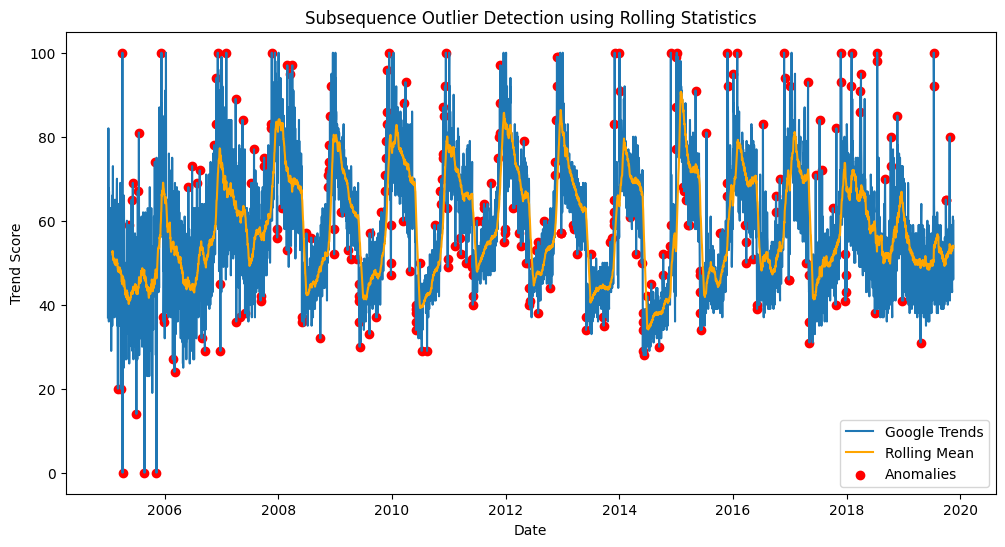

In [16]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Google_Trends'], label='Google Trends')
plt.plot(data.index, data['Rolling_Mean'], color='orange', label='Rolling Mean')
plt.scatter(data.index[data['Anomaly_Subsequence']], data['Google_Trends'][data['Anomaly_Subsequence']], color='red', label='Anomalies')
plt.title('Subsequence Outlier Detection using Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Trend Score')
plt.legend()
plt.show()

In [17]:
# Perform STL decomposition
stl = STL(data['Google_Trends'], period=365)
result = stl.fit()

# Add components to the DataFrame
data['Trend'] = result.trend
data['Seasonal'] = result.seasonal
data['Residual'] = result.resid

In [18]:
# Calculate residual Z-Score
data['Residual_Z'] = (data['Residual'] - data['Residual'].mean()) / data['Residual'].std()

# Detect anomalies
data['Anomaly_STL'] = np.abs(data['Residual_Z']) > threshold

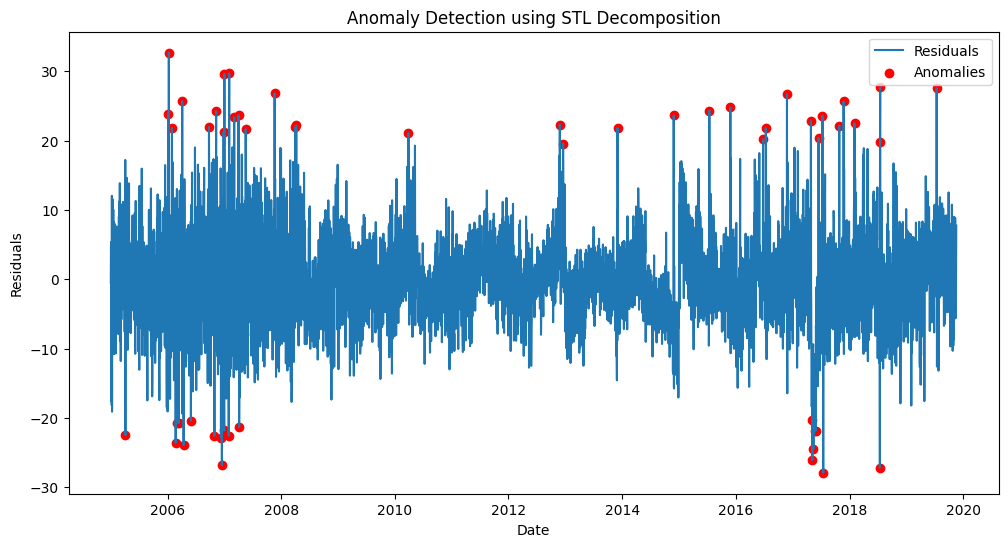

In [19]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Residual'], label='Residuals')
plt.scatter(data.index[data['Anomaly_STL']], data['Residual'][data['Anomaly_STL']], color='red', label='Anomalies')
plt.title('Anomaly Detection using STL Decomposition')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [20]:
# Create lag features
data['Lag_1'] = data['Google_Trends'].shift(1)
data['Lag_2'] = data['Google_Trends'].shift(2)
data['Lag_3'] = data['Google_Trends'].shift(3)

# Drop NaN values
data_cart = data.dropna(subset=['Lag_1', 'Lag_2', 'Lag_3'])

In [21]:
# Features and target
X_cart = data_cart[['Lag_1', 'Lag_2', 'Lag_3']]
y_cart = data_cart['Google_Trends']

In [22]:
# Initialize and train the model
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_cart, y_cart)

DecisionTreeClassifier(random_state=42)

In [23]:
# Predict the target
y_pred_cart = cart_model.predict(X_cart)

# Calculate residuals
data_cart['Residuals_Cart'] = y_cart - y_pred_cart

# Detect anomalies
data_cart['Anomaly_CART'] = np.abs(data_cart['Residuals_Cart']) > (2 * data_cart['Residuals_Cart'].std())


<ipython-input-23-ed236598d14c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cart['Residuals_Cart'] = y_cart - y_pred_cart
<ipython-input-23-ed236598d14c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cart['Anomaly_CART'] = np.abs(data_cart['Residuals_Cart']) > (2 * data_cart['Residuals_Cart'].std())


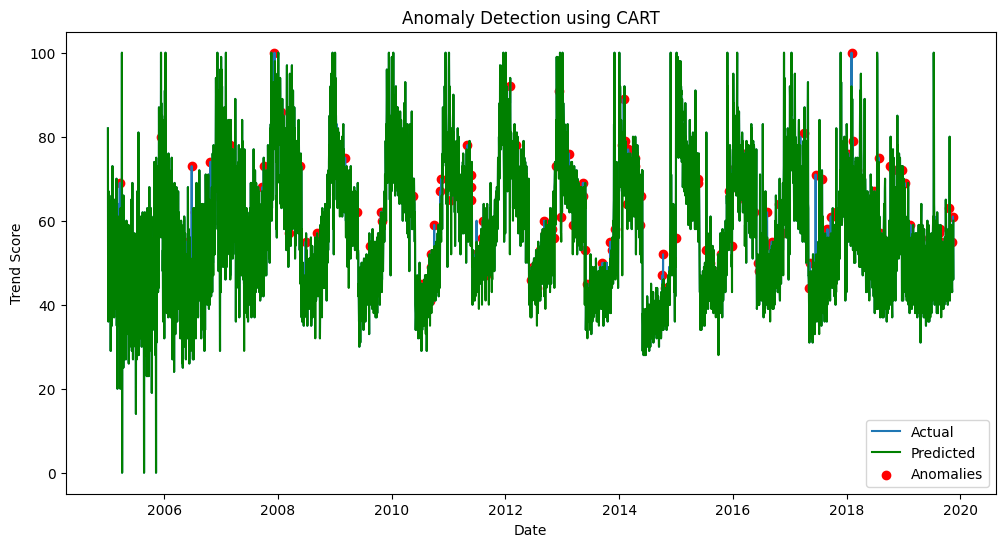

In [24]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data_cart.index, y_cart, label='Actual')
plt.plot(data_cart.index, y_pred_cart, color='green', label='Predicted')
plt.scatter(data_cart.index[data_cart['Anomaly_CART']], y_cart[data_cart['Anomaly_CART']], color='red', label='Anomalies')
plt.title('Anomaly Detection using CART')
plt.xlabel('Date')
plt.ylabel('Trend Score')
plt.legend()
plt.show()

In [25]:
# Prepare the data
X = data['Google_Trends'].values.reshape(-1, 1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the model
iforest = IForest(random_state=42)
iforest.fit(X_scaled)

# Predict anomalies (-1 for anomalies)
data['Anomaly_IForest'] = iforest.predict(X_scaled) == -1

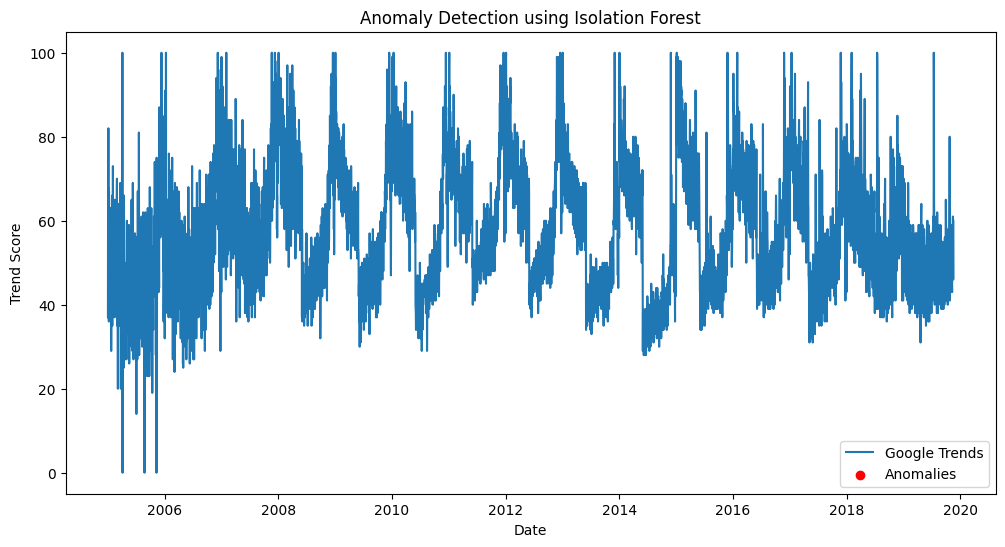

In [34]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Google_Trends'], label='Google Trends')
plt.scatter(data.index[data['Anomaly_IForest']], data['Google_Trends'][data['Anomaly_IForest']], color='red', label='Anomalies')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Trend Score')
plt.legend()
plt.show()


In [27]:
# Split data into training and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data['Google_Trends'][:train_size], data['Google_Trends'][train_size:]

# Fit ARIMA model
arima_order = (5, 1, 0)
arima_model = ARIMA(train_data, order=arima_order)
arima_model_fit = arima_model.fit()

# Forecast
forecast = arima_model_fit.forecast(steps=len(test_data))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
# Calculate residuals
residuals = test_data - forecast

# Detect anomalies
residual_std = residuals.std()
data['Anomaly_ARIMA'] = False
data['Anomaly_ARIMA'].iloc[train_size:] = np.abs(residuals) > (2 * residual_std)

<ipython-input-28-9fc9aef7ffe2>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Anomaly_ARIMA'].iloc[train_size:] = np.abs(residuals) > (2 * residual_std)
<ipython-input-28-9fc9aef7ffe2>:7: SettingWithCopyWarning: 
A value is trying t

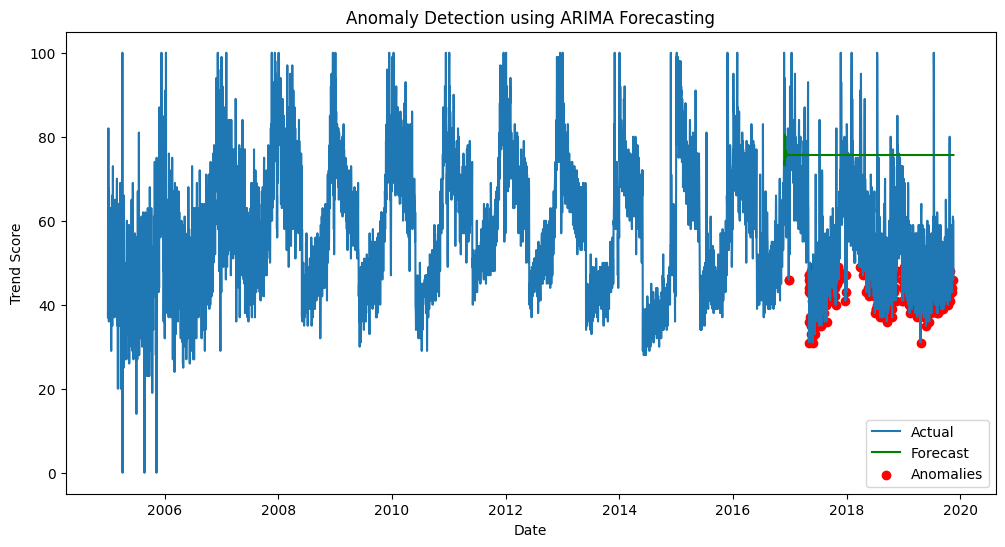

In [29]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Google_Trends'], label='Actual')
plt.plot(test_data.index, forecast, color='green', label='Forecast')
plt.scatter(test_data.index[data['Anomaly_ARIMA'].iloc[train_size:]], test_data[data['Anomaly_ARIMA'].iloc[train_size:]], color='red', label='Anomalies')
plt.title('Anomaly Detection using ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Trend Score')
plt.legend()
plt.show()